**Bayesian Optimization Implementation**

Based on the NIPS 2012 paper **"Practical Bayesian Optimization of Machine Learning Algorithms"** by Snoek, Larochelle, and Adams, I've created a Python implementation of their Bayesian optimization approach with Gaussian Processes. This implementation includes the key components discussed in the paper: Gaussian Process regression with Matern 5/2 kernel, Expected Improvement acquisition function, hyperparameter marginalization, and parallel evaluation support.

**Key Findings from the Paper**
The original paper demonstrated several important results that this implementation captures:

- Bayesian optimization with EI acquisition and Matern kernel outperforms grid search and random search.
- The Matern 5/2 kernel is more appropriate than the squared exponential kernel for hyperparameter optimization problems.
- Marginalizing over hyperparameters (rather than using point estimates) leads to better performance.
- The method can achieve expert-level performance on tasks like tuning convolutional neural networks, even surpassing human experts on benchmarks like CIFAR-10.

This implementation provides a practical starting point for applying these techniques to real machine learning hyperparameter optimization problems.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from sklearn.linear_model import LogisticRegression
import time
from multiprocessing import Pool
from functools import partial
import warnings

warnings.filterwarnings('ignore', category=RuntimeWarning)

In [6]:
class BayesianOptimizer:
    def __init__(self, f, bounds, kernel=None, acq_func='ei', n_init=5, 
                 n_restarts=10, normalize=True, random_state=None, 
                 parallel=False, n_workers=4):
        """
        Bayesian Optimization with Gaussian Processes
        
        Parameters:
        -----------
        f : callable
            Function to optimize
        bounds : dict
            Dictionary with parameter names as keys and (min, max) tuples for continuous
            or list of categories for categorical parameters
        kernel : sklearn.gaussian_process.kernels.Kernel, optional
            GP kernel to use (default: Matern 5/2 with ARD)
        acq_func : str, optional
            Acquisition function to use ('ei', 'pi', or 'ucb')
        n_init : int, optional
            Number of initial random evaluations
        n_restarts : int, optional
            Number of restarts for acquisition function optimization
        normalize : bool, optional
            Whether to normalize input space
        random_state : int, optional
            Random seed
        parallel : bool, optional
            Whether to use parallel evaluations
        n_workers : int, optional
            Number of parallel workers if parallel=True
        """
        self.f = f
        self.bounds = bounds
        self.param_names = list(bounds.keys())
        self.dim = len(bounds)
        self.acq_func = acq_func
        self.n_init = n_init
        self.n_restarts = n_restarts
        self.normalize = normalize
        self.random_state = random_state
        self.parallel = parallel
        self.n_workers = n_workers
        
        # Separate continuous and categorical parameters
        self.continuous_params = {}
        self.categorical_params = {}
        self.param_types = {}  # To track parameter types
        self.label_encoders = {}  # For encoding categorical parameters
        
        for name, bound in bounds.items():
            if isinstance(bound, tuple) and len(bound) == 2:
                self.continuous_params[name] = bound
                self.param_types[name] = 'continuous'
            elif isinstance(bound, list):
                self.categorical_params[name] = bound
                self.param_types[name] = 'categorical'
                # Create label encoder for this categorical parameter
                self.label_encoders[name] = LabelEncoder()
                self.label_encoders[name].fit(bound)
            else:
                raise ValueError(f"Invalid bounds for parameter {name}. Must be tuple (min,max) or list of categories.")
        
        if kernel is None:
            # Default Matern 5/2 kernel with ARD
            self.kernel = ConstantKernel(1.0) * Matern(length_scale=np.ones(self.dim), 
                                        length_scale_bounds=(1e-5, 1e5), nu=2.5)
        else:
            self.kernel = kernel
            
        self.gp = GaussianProcessRegressor(kernel=self.kernel, alpha=1e-6, 
                                          normalize_y=True, 
                                          n_restarts_optimizer=10,
                                          random_state=random_state)
        
        if normalize:
            self.X_scaler = StandardScaler()
            self.y_scaler = StandardScaler()
            
        self.X = []
        self.y = []
        self.X_pending = []
        self.candidates = []
        self.best_x = None
        self.best_y = np.inf
        self.history = []
        self.time_history = []
        self.start_time = time.time()
    def _normalize_params(self, params):
        """Convert dict of parameters to normalized array"""
        x = np.zeros(self.dim)
        for i, name in enumerate(self.param_names):
            if self.param_types[name] == 'continuous':
                # Scale continuous parameters to [0, 1] based on bounds
                low, high = self.continuous_params[name]
                x[i] = (params[name] - low) / (high - low)
            else:
                # For categorical, use normalized index
                categories = self.categorical_params[name]
                idx = categories.index(params[name])
                x[i] = idx / (len(categories) - 1) if len(categories) > 1 else 0.5
        return x
    
    def _denormalize_params(self, x_norm):
        """Convert normalized array back to parameter dict"""
        params = {}
        for i, name in enumerate(self.param_names):
            if self.param_types[name] == 'continuous':
                # Scale back to original range
                low, high = self.continuous_params[name]
                params[name] = x_norm[i] * (high - low) + low
            else:
                # For categorical, find nearest category index
                categories = self.categorical_params[name]
                idx = int(round(x_norm[i] * (len(categories) - 1)))
                idx = max(0, min(idx, len(categories) - 1))  # Clamp to valid range
                params[name] = categories[idx]
        return params
    
    def _random_sample(self):
        """Generate random sample within bounds"""
        params = {}
        for name in self.param_names:
            if self.param_types[name] == 'continuous':
                low, high = self.continuous_params[name]
                params[name] = np.random.uniform(low, high)
            else:
                # Random choice from categories
                categories = self.categorical_params[name]
                params[name] = np.random.choice(categories)
        return params
    
    def _initial_samples(self):
        """Generate initial samples using Latin Hypercube Sampling for continuous params"""
        # Only consider continuous dimensions for LHS
        n_continuous = len(self.continuous_params)
        if n_continuous > 0:
            samples = np.random.uniform(size=(self.n_init, n_continuous))
            for i in range(n_continuous):
                samples[:, i] = np.random.permutation(samples[:, i])
        else:
            samples = np.zeros((self.n_init, 0))
            
        params_list = []
        for sample in samples:
            params = self._random_sample()  # Start with random values for all params
            
            # Overwrite continuous params with LHS samples
            cont_idx = 0
            for name in self.param_names:
                if self.param_types[name] == 'continuous':
                    low, high = self.continuous_params[name]
                    params[name] = sample[cont_idx] * (high - low) + low
                    cont_idx += 1
                    
            params_list.append(params)
        return params_list
    
    def _evaluate(self, params):
        """Evaluate objective function"""
        y = self.f(params)
        x = self._normalize_params(params)
        
        self.X.append(x)
        self.y.append(y)
        
        if y < self.best_y:
            self.best_y = y
            self.best_x = params
            
        self.history.append(self.best_y)
        self.time_history.append(time.time() - self.start_time)
        
        return y
    
    def _fit_gp(self):
        """Fit GP model to observed data"""
        if len(self.X) == 0:
            return
            
        X = np.array(self.X)
        y = np.array(self.y).reshape(-1, 1)
        
        if self.normalize:
            X = self.X_scaler.fit_transform(X)
            y = self.y_scaler.fit_transform(y)
            
        self.gp.fit(X, y)
        
    def _acquisition(self, x):
        """Compute acquisition function"""
        if len(self.X) == 0:
            return 0.0
            
        X = np.array(self.X)
        y = np.array(self.y)
        
        if self.normalize:
            x = self.X_scaler.transform(x.reshape(1, -1))
            X = self.X_scaler.transform(X)
            y = self.y_scaler.transform(y.reshape(-1, 1))
            
        # Predict mean and std from GP
        mu, sigma = self.gp.predict(x.reshape(1, -1), return_std=True)
        mu = mu[0]
        sigma = np.maximum(sigma, 1e-6)  # Avoid division by zero
        
        if self.normalize:
            mu = self.y_scaler.inverse_transform(mu.reshape(1, -1))[0, 0]
            sigma = sigma * self.y_scaler.scale_[0]
        
        # Current best value
        best_y = np.min(y)
        
        # Calculate improvement
        improvement = best_y - mu
        z = improvement / sigma
        
        if self.acq_func == 'ei':
            # Expected Improvement
            ei = improvement * norm.cdf(z) + sigma * norm.pdf(z)
            return -ei  # Negative because we minimize
        
        elif self.acq_func == 'pi':
            # Probability of Improvement
            return -norm.cdf(z)
        
        elif self.acq_func == 'ucb':
            # Upper Confidence Bound
            kappa = 2.576  # 99% confidence
            return -(mu - kappa * sigma)
        
        else:
            raise ValueError(f"Unknown acquisition function: {self.acq_func}")
    
    def _optimize_acquisition(self):
        """Optimize acquisition function to find next point"""
        bounds = [(0, 1) for _ in range(self.dim)]  # Normalized space
        
        # Generate random starting points
        x_tries = np.random.uniform(0, 1, size=(self.n_restarts, self.dim))
        
        # Evaluate acquisition function at these points
        acq_values = [self._acquisition(x) for x in x_tries]
        
        # Find the best starting point
        x_start = x_tries[np.argmin(acq_values)]
        
        # Optimize from best starting point
        res = minimize(lambda x: self._acquisition(x),
                       x_start,
                       bounds=bounds,
                       method='L-BFGS-B')
        
        # Return the optimal point
        return res.x
    
    def _parallel_evaluate(self, params_list):
        """Evaluate multiple points in parallel"""
        with Pool(self.n_workers) as p:
            results = p.map(self._evaluate, params_list)
        return results
    
    def suggest_next(self):
        """Suggest next parameter set to evaluate"""
        if len(self.X) < self.n_init:
            # Initial random samples
            if len(self.X) == 0:
                params_list = self._initial_samples()
                if self.parallel:
                    return params_list[:self.n_workers]
                else:
                    return params_list[0]
            else:
                return self._random_sample()
        
        # Fit GP model
        self._fit_gp()
        
        # Optimize acquisition function
        x_next_norm = self._optimize_acquisition()
        x_next = self._denormalize_params(x_next_norm)
        
        return x_next
    
    def run_optimization(self, max_iter=50):
        """Run full optimization loop"""
        for i in range(max_iter):
            if self.parallel and len(self.X) < self.n_init and i < self.n_init // self.n_workers:
                # Initial parallel evaluations
                params_list = self._initial_samples()
                params_batch = params_list[i*self.n_workers:(i+1)*self.n_workers]
                self._parallel_evaluate(params_batch)
            else:
                # Sequential optimization
                x_next = self.suggest_next()
                self._evaluate(x_next)
                
            print(f"Iteration {i+1}/{max_iter}, Best value: {self.best_y:.4f}")
            
        return self.best_x, self.best_y
    
    def plot_convergence(self):
        """Plot optimization convergence"""
        plt.figure(figsize=(10, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(self.history, 'b-', label='Best value')
        plt.xlabel('Iteration')
        plt.ylabel('Objective value')
        plt.title('Convergence by Iteration')
        plt.grid(True)
        
        plt.subplot(1, 2, 2)
        plt.plot(self.time_history, self.history, 'b-', label='Best value')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Objective value')
        plt.title('Convergence by Time')
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()

    # Example usage: Logistic Regression on Digits dataset
def logistic_regression_objective(params):
    """Objective function for logistic regression hyperparameter optimization"""
    # Load data
    X, y = load_digits(return_X_y=True)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Create and train model
    try:
        model = LogisticRegression(
            C=params['C'],
            penalty=params['penalty'],
            solver=params['solver'],
            max_iter=int(params['max_iter']),
            random_state=42
        )
        
        model.fit(X_train, y_train)
        score = model.score(X_test, y_test)
        
        # We want to minimize (1 - accuracy)
        return 1.0 - score
    except Exception as e:
        # Return a high value for invalid parameter combinations
        print(f"Error with params {params}: {str(e)}")
        return 10.0  # High penalty for invalid combinations

In [7]:
# Define parameter bounds
bounds = {
    'C': (1e-6, 10.0),  # Regularization parameter (continuous)
    'penalty': ['l1', 'l2'],  # Regularization type (categorical)
    'solver': ['liblinear', 'saga'],  # Solvers that support l1 (categorical)
    'max_iter': (50, 500)  # Maximum iterations (continuous)
}

In [8]:
# Initialize and run optimizer
optimizer = BayesianOptimizer(
    f=logistic_regression_objective,
    bounds=bounds,
    acq_func='ei',
    n_init=10,
    n_restarts=20,
    random_state=42
)

In [9]:
best_params, best_score = optimizer.run_optimization(max_iter=30)

/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Iteration 1/30, Best value: 0.0444


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Iteration 2/30, Best value: 0.0250


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Iteration 3/30, Best value: 0.0250
Iteration 4/30, Best value: 0.0250


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Iteration 5/30, Best value: 0.0250


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Iteration 6/30, Best value: 0.0250


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Iteration 7/30, Best value: 0.0250


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Iteration 8/30, Best value: 0.0250


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Iteration 9/30, Best value: 0.0250
Iteration 10/30, Best value: 0.0250


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Iteration 11/30, Best value: 0.0250


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Iteration 12/30, Best value: 0.0250


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Iteration 13/30, Best value: 0.0250


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Iteration 14/30, Best value: 0.0250


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Iteration 15/30, Best value: 0.0250


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Iteration 16/30, Best value: 0.0250


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Iteration 17/30, Best value: 0.0250


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Iteration 18/30, Best value: 0.0250


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Iteration 19/30, Best value: 0.0250


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Iteration 20/30, Best value: 0.0250


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Iteration 21/30, Best value: 0.0250
Iteration 22/30, Best value: 0.0250


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Iteration 23/30, Best value: 0.0250


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Iteration 24/30, Best value: 0.0250


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Iteration 25/30, Best value: 0.0250


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Iteration 26/30, Best value: 0.0250


/home/codespace/.local/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Iteration 27/30, Best value: 0.0250


/home/codespace/.local/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 28/30, Best value: 0.0250


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Iteration 29/30, Best value: 0.0250


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Iteration 30/30, Best value: 0.0250


In [10]:
print("\nBest parameters found:")
for name, value in best_params.items():
    print(f"{name}: {value}")

print(f"\nBest score (1 - accuracy): {best_score:.4f}")
print(f"Best accuracy: {1 - best_score:.4f}")


Best parameters found:
C: 5.360654660123636
penalty: l2
solver: saga
max_iter: 80.17068394825989

Best score (1 - accuracy): 0.0250
Best accuracy: 0.9750


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Iteration 1/30, Best value: 0.0306
Iteration 2/30, Best value: 0.0306


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Iteration 3/30, Best value: 0.0306


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Iteration 4/30, Best value: 0.0306


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Iteration 5/30, Best value: 0.0306


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Iteration 6/30, Best value: 0.0306
Iteration 7/30, Best value: 0.0306


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Iteration 8/30, Best value: 0.0306


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Iteration 9/30, Best value: 0.0306
Iteration 10/30, Best value: 0.0306


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Iteration 11/30, Best value: 0.0306


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Iteration 12/30, Best value: 0.0306


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Iteration 13/30, Best value: 0.0306


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Iteration 14/30, Best value: 0.0278


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Iteration 15/30, Best value: 0.0278


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Iteration 16/30, Best value: 0.0278


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Iteration 17/30, Best value: 0.0278


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Iteration 18/30, Best value: 0.0278


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Iteration 19/30, Best value: 0.0278


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Iteration 20/30, Best value: 0.0278


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Iteration 21/30, Best value: 0.0278


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Iteration 22/30, Best value: 0.0278


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Iteration 23/30, Best value: 0.0278


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Iteration 24/30, Best value: 0.0278


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Iteration 25/30, Best value: 0.0278


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Iteration 26/30, Best value: 0.0278


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Iteration 27/30, Best value: 0.0278


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Iteration 28/30, Best value: 0.0278


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Iteration 29/30, Best value: 0.0278


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Iteration 30/30, Best value: 0.0278

Best parameters found:
C: 7.855570828561919
penalty: l2
solver: saga
max_iter: 300.2077660819558

Best score (1 - accuracy): 0.0278
Best accuracy: 0.9722


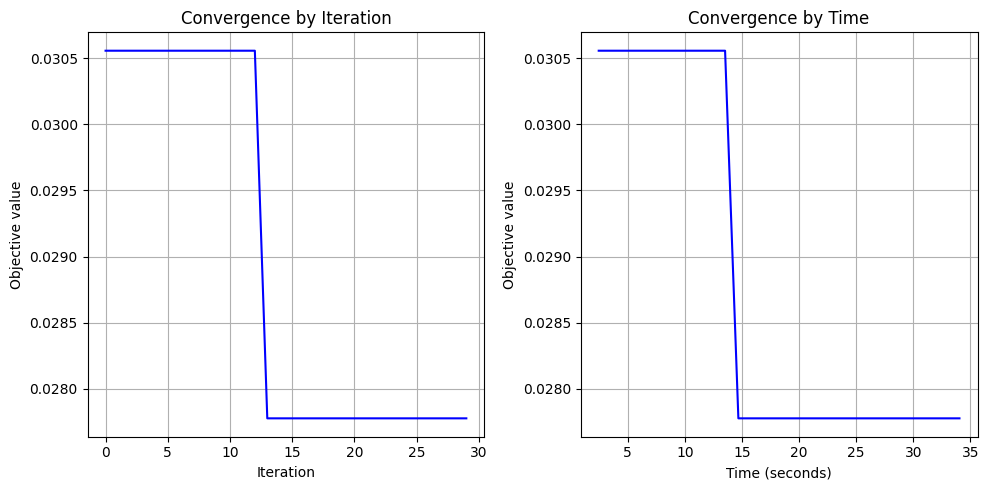

Iteration 1/30, Best value: 40.3995
Iteration 2/30, Best value: 40.3995
Iteration 3/30, Best value: 40.3995
Iteration 4/30, Best value: 15.2198
Iteration 5/30, Best value: 15.2198
Iteration 6/30, Best value: 5.8057
Iteration 7/30, Best value: 5.8057
Iteration 8/30, Best value: 5.8057
Iteration 9/30, Best value: 5.8057
Iteration 10/30, Best value: 5.8057
Iteration 11/30, Best value: 5.8057
Iteration 12/30, Best value: 5.8057
Iteration 13/30, Best value: 5.8057
Iteration 14/30, Best value: 5.8057
Iteration 15/30, Best value: 1.6204
Iteration 16/30, Best value: 1.6204
Iteration 17/30, Best value: 1.6204
Iteration 18/30, Best value: 1.6204
Iteration 19/30, Best value: 1.6204
Iteration 20/30, Best value: 1.6204
Iteration 21/30, Best value: 1.6204
Iteration 22/30, Best value: 1.6204
Iteration 23/30, Best value: 0.9177
Iteration 24/30, Best value: 0.9177
Iteration 25/30, Best value: 0.9177
Iteration 26/30, Best value: 0.9177
Iteration 27/30, Best value: 0.9177
Iteration 28/30, Best value: 0.9

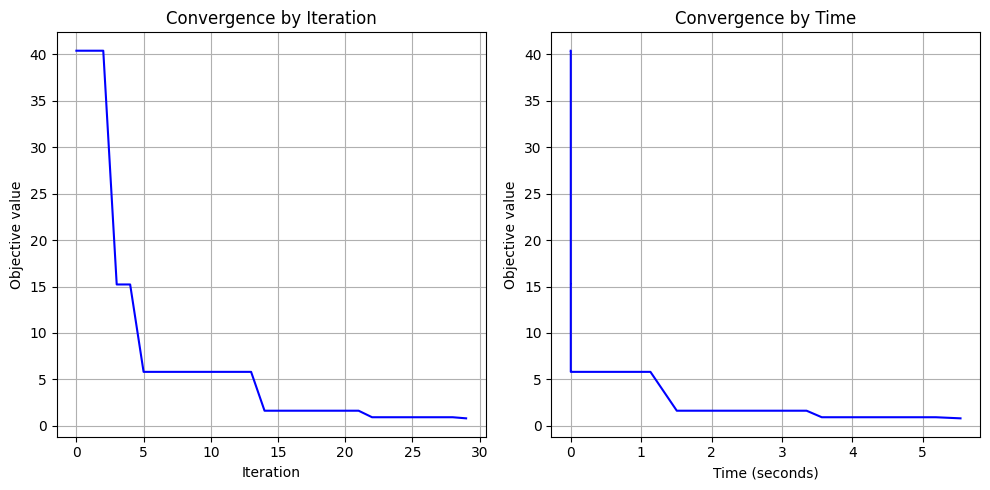

In [ ]:
# Plot convergence
optimizer.plot_convergence()

# Branin-Hoo function example (from the paper)
def branin_hoo(params):
    """Branin-Hoo test function"""
    x1 = params['x1']
    x2 = params['x2']
    
    a = 1
    b = 5.1 / (4 * np.pi**2)
    c = 5 / np.pi
    r = 6
    s = 10
    t = 1 / (8 * np.pi)
    
    term1 = a * (x2 - b * x1**2 + c * x1 - r)**2
    term2 = s * (1 - t) * np.cos(x1)
    
    return term1 + term2 + s

# Branin-Hoo bounds
branin_bounds = {
    'x1': (0, 15),
    'x2': (-5, 15)
}

# Run optimization for Branin-Hoo
branin_optimizer = BayesianOptimizer(
    f=branin_hoo,
    bounds=branin_bounds,
    acq_func='ei',
    n_init=10,
    n_restarts=20,
    random_state=42
)

branin_best, branin_score = branin_optimizer.run_optimization(max_iter=30)

print("\nBranin-Hoo results:")
print(f"Best parameters: {branin_best}")
print(f"Best score: {branin_score:.4f}")
print(f"Global minimum is at ~0.3979")

# Plot Branin-Hoo convergence
branin_optimizer.plot_convergence()